<hr style="height: 4px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='#38610B'>Projet VI - Détection de Faux Billets</font>


### Mission 3 - Régression Logistique : programme de détection

  
**<font color='#38610B'>- Date : 15 Juin 2019</font>**  
Auteur : Frédéric Boissy
<hr style="height: 4px; color: #839D2D; width: 100%; ">


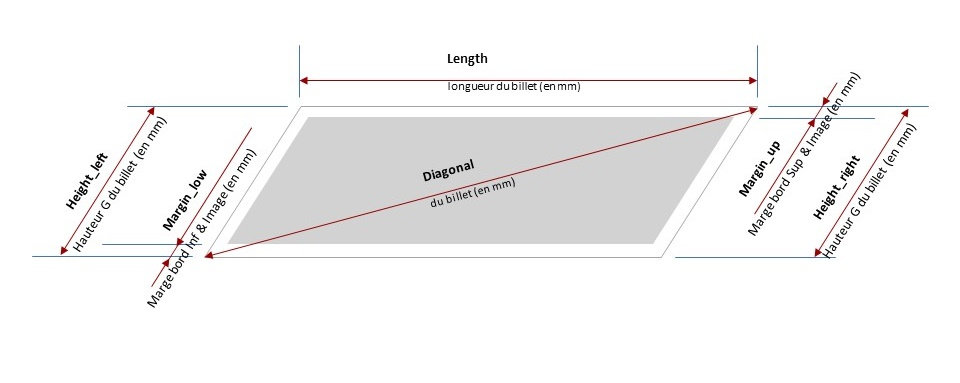

#### Initialisation (Libraries - Functions - etc...)

In [1]:
# -*- coding: utf8 -*-
from init_libraries import *
from functions      import *
from functions2     import *

import time   # Librairie temps pour calculs durée par exemple
trt_start_time = time.time()

<hr style="height: 3px; color: #839D2D; width: 100%; ">

### <font color='#61210B'>IMPORT DATAS</font>

In [2]:
df       = pd.read_csv("OUTFILES/df.csv")
dfacp    = pd.read_csv("OUTFILES/dfacp.csv")
dfk      = pd.read_csv("OUTFILES/dfk.csv")
dfk.info()
dfk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 6 columns):
F1            170 non-null float64
F2            170 non-null float64
F3            170 non-null float64
F4            170 non-null float64
is_genuine    170 non-null int64
clusterk      170 non-null int64
dtypes: float64(4), int64(2)
memory usage: 8.1 KB


,F1,F2,F3,F4,is_genuine,clusterk
0,2.15,1.60,1.79,2.43,1,0
1,-2.11,-0.53,0.54,0.34,1,1
2,-1.97,-0.05,0.86,0.37,1,1
3,-2.06,-0.09,-0.53,0.52,1,1
4,-2.40,0.41,3.32,-0.84,1,1


### <font color="blue">Rappel Resultat K-Means</font>
<img src="OUTFILES/Matrice_conf_kmeans.png" width="300" ALIGN='left'>


### INITIALISATION DES VARIABLES X et Y avec les données du Dataframe

- <b> X = F1+F2+F3+F4</b>, variables explicatives du modèle (issues de l'ACP)   
- <b> Y = is_genuine</b>, vraie valeur cible (ici is_genuine)

In [3]:
X = dfk[['F1', 'F2', 'F3', 'F4']].values
Y = dfk['is_genuine'].values
Y.astype(int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# <font color='#0080FF'>Regression Logistique sur </font>
 - <b>X = F1 - F2 - F3 - F4</b>  - Données issues de l'ACP
 
C'est à nous de définir la proportion du dataset que vous souhaitez allouer à chaque partie.  
En général, les données sont séparées avec les proportions suivantes :  
- 80 % pour le training set  
- 20 % pour le testing set.

Ici nous avons peu de données (170)

- <b>1. </b>Preparation (SPLIT) des Bases de données "Training" et "Predictions" à partir de notre Dataset <b><font color='blue'>"TRAIN"</font> / <font color='darkred'>"TEST"</font></b>  
- <b>2. </b>Construction du Modele de Regression Logistique sur la Base "TRAIN" : <font color='blue'><b>logreg</font></b> = f(x_train)   
- <b>3. </b>Calcul des prédictions et de la matrice de confusion sur la Base  <font color='darkred'><b>"TEST"</font></b>  
- <b>4. </b>Calcul des probabilités de chaque ligne de la Base "TEST" <font color='darkred'><b>y_proba</font></b>  


- <b>5. </b>Construction de la courbe <font color='darkred'><b>ROC</font></b> montrant la répartition des predictions bien classées et des mal classées  
    Tout d’abord les coordonnées des points.  
    Le modèle prédit bien si le modèle trouve la bonne classe ce qu’on traduit par y_pred == y_test.  
    Le score est celui de la classe prédite : y_score[y_pred].  


- <b>6. </b>Détermination de l'aire sous courbe <font color='darkred'><b>AUC</font></b> (Area Under the Curve) qui montre la pertinence du modèle.  
Plus le score est elevé, plus on s’attend à ce que la proportion d’exemples bien classés soit grande par rapport à la proportion d’exemple mal classés.   
A l’inverse, quand ces proportions sont toujours égales quelque soit le sueil, la courbe correspond à la première diagonale et le modèle n’a rien appris.   
Plus la courbe est haute, meilleur le modèle est.  
C’est pourquoi on calcule l’aire sous la courbe.

----------------------------------------------------------
Taille Base Apprentissage =  60 (%)
----------------------------------------------------------
Matrice de Confusion sur Base Test
[[22  0]
 [ 3 43]]
----------------------------------------------------------


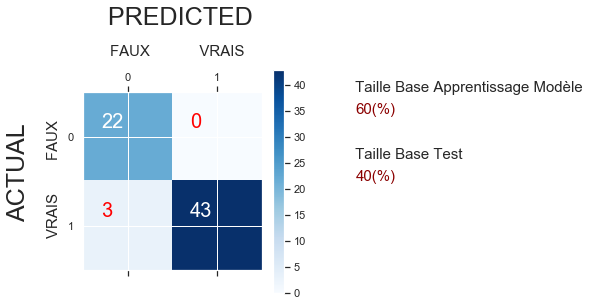

Probabilités appartenance aux clusters des lignes Bases Test (3 premieres lignes
[[0.9886 0.0114]
 [0.1315 0.8685]
 [0.0027 0.9973]]


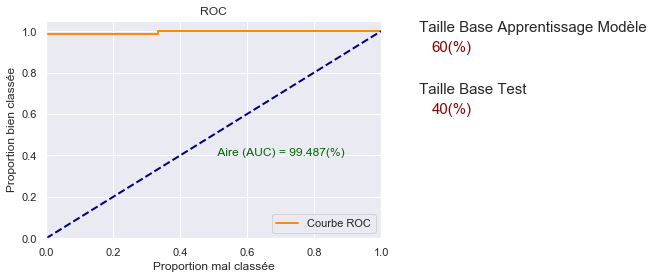

Aire sous la Courbe (AUC) = 99.487 (%)


In [4]:
sns.set()
# tx_split = int(input("veuillez entrer le taux (%) pour la base Training(pour 80%, saisir 80) ... "))
tx_split = 60
# 1 - On spécifie le pourcentage de training avec train_size
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=tx_split/100)

# 2 - Construction Modèle
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("----------------------------------------------------------")
print("Taille Base Apprentissage = ", tx_split, "(%)")
# print("---------------------------------------------------------------------------------------------------------")
# print("Base Apprentissage >>> ", "Xn = ", logreg.coef_, "      Y =", logreg.intercept_)
# print("---------------------------------------------------------------------------------------------------------")

# 3 - Calcul prédictions et Matrice Confusion Base Test
y_pred = logreg.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
print("----------------------------------------------------------")
print("Matrice de Confusion sur Base Test")
print(conf)
print("----------------------------------------------------------")

im_mat = plt.matshow(conf, cmap=plt.cm.Blues)
plt.colorbar(im_mat)
plt.text(-0.3,-1.25, " PREDICTED", size=25)
plt.text(-0.2,-0.9, "FAUX            VRAIS", size=15)
plt.text(-0.3,-0.1, (conf[0,0]), color = 'white', size=20)
plt.text(-0.3, 0.9, (conf[1,0]), color = 'red', size=20)
plt.text(-1.35, 0.9, "ACTUAL", size=25, rotation=90)
plt.text(-0.9,1.1, "VRAIS        FAUX", size=15, rotation=90)
plt.text(0.7, -0.1, (conf[0,1]), color = 'red', size=20)
plt.text(0.7, 0.9, (conf[1,1]), color = 'white', size=20)

plt.text(2.5,-0.5, " Taille Base Apprentissage Modèle", size=15)
plt.text(2.55,-0.25, str(tx_split) + "(%)", size=15, color="darkred")
plt.text(2.5,0.25, " Taille Base Test", size=15)
plt.text(2.55,0.5, str(100-tx_split) + "(%)", size=15, color="darkred")


plt.savefig('OUTFILES/Modele_Matrice_conf_kmeans.png', dpi=100, bbox_inches='tight')
plt.show()


# 4 - Calcul proba appartenance aux groupes prédictions et Matrice Confusion Base Test
y_proba = logreg.predict_proba(X_test)
np.set_printoptions(precision=4, suppress=True)
print("Probabilités appartenance aux clusters des lignes Bases Test (3 premieres lignes")
print(y_proba[:3])

# 5 -Construction de la courbe ROC. 
prob_pred = [y_proba[i, c] for i, c in enumerate(y_pred)]
fpr, tpr, th = roc_curve((y_pred == y_test).ravel(), prob_pred)
# Tracé
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Proportion mal classée")
plt.ylabel("Proportion bien classée")
plt.title('ROC')
plt.legend(loc="lower right")

# 6 - Calcul de l'aire sous la courbe AUC
AIRE = auc(fpr, tpr) 
text_aire = " Aire (AUC) = " + str(round(AIRE*100, 3)) + "(%)"
plt.text(0.5,0.4, text_aire, size=12, color = 'darkgreen')
plt.text(1.1,1, " Taille Base Apprentissage Modèle", size=15)
plt.text(1.15,0.9, str(tx_split) + "(%)", size=15, color="darkred")
plt.text(1.1,0.7, " Taille Base Test", size=15)
plt.text(1.15,0.6, str(100-tx_split) + "(%)", size=15, color="darkred")


plt.savefig('OUTFILES/Modele_Courbe_ROC.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Aire sous la Courbe (AUC) =", round(AIRE*100, 3), "(%)")

<hr style="height: 3px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>PROGRAMME</font>

### VERIFICATION MODELE 

#### En utilisant un centrage réduction et ACP sur fichier à tester
* Prenons un fichier basé sur 3 billets dont on est sûr qu'ils soient faux

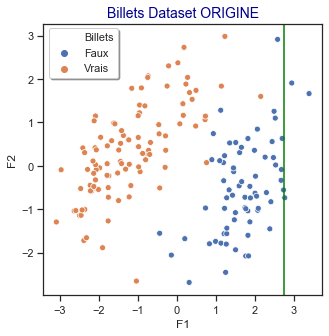

In [5]:
sns.set_style("ticks")
plt.figure(figsize = (5, 5))
sns.scatterplot(x=dfk.F1, y=dfk.F2, hue="is_genuine",  data=dfk)
legend2 = plt.legend(loc=(0.02,0.8), shadow=True)
legend2.texts[0].set_text("Billets")
legend2.texts[1].set_text("Faux")
legend2.texts[2].set_text("Vrais")
plt.axvline(2.75, color="green")
plt.title("Billets Dataset ORIGINE", size=14, color='darkblue')
plt.savefig('OUTFILES/Billets_DataSet_Origine.png', dpi=100, bbox_inches='tight')
plt.show()

In [6]:
dfacp[dfacp['F1'] > 2.75]

,F1,F2,F3,F4,F5,F6
112,2.95,1.91,-0.49,1.17,-0.70,-0.07
122,3.39,1.66,1.39,0.64,-0.42,-0.10
158,2.77,-0.74,2.01,-0.36,-0.34,-0.49


In [7]:
# ///////////  TEST  //////////////
df = pd.read_csv("DATA/notes.csv")
# Preparation d'une fichier a tester avec 3 faux billets pris dans le jeu de données initial
# liste3b = np.random.randint(101,170,3)
liste3b = np.array([112, 122, 158])
df3b = df[df.index.isin(liste3b)].copy()
# Retrait de ces 3 billets du jeu de données initial
df = df.drop(liste3b)
df3b['id'] = ["A_"+str(i+1) for i in range(3)]
df3b.drop(columns = ['is_genuine'], inplace=True)

# Chargement du fichier à Evaluer et Préformattage (acp) avant application Modèle
# ex = pd.read_csv("example.csv")
ex = df3b

ex1 = ex.drop(columns = 'id').values
# Préparation Données pour modele Regression Logistique
x = df.copy()
x = df.drop(columns = 'is_genuine').values
y = df['is_genuine'].values
y.astype(int)

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)
ex_scaled = std_scale.transform(ex1)

# Calcul des composantes principales
n_comp = 3                                      # choix du nombre de composantes à calculer
pca = decomposition.PCA(n_components=n_comp)
pca.fit(x_scaled)
x_projected = pca.fit_transform(x_scaled)
# ex_projected = pca.fit_transform(ex_scaled)
ex_projected = pca.transform(ex_scaled)

# Création du Modèle de regression Logistique sur notre Dataset
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(x_projected, y)

# Traitement Prédictions sur fichier Test (example) et sortie dans un Dataframe
e  = ex.count()
if e["id"] > 0 : 
    y_pred = logreg.predict(ex_projected)
    tx_conf = logreg.predict_proba(ex_projected)
    i = tx_conf[:,0]
    ex["Probabilité d'authenticité(%)"] = np.round((100-i*100), 2)
    ex["Prediction"] = y_pred
    ex = ex.replace({'Prediction' : 1}, "Le billet est Faux")
    ex = ex.replace({'Prediction' : 0}, "Le billet est Vrai")
else : 
    print("Fichier vide")
    
print("Nombre de billets : ",e["id"])
ex.head()

Nombre de billets :  3


,diagonal,height_left,height_right,margin_low,margin_up,length,id,Probabilité d'authenticité(%),Prediction
112,172.32,104.60,104.83,4.84,3.51,112.55,A_1,2.20,False
122,172.29,104.72,104.86,5.71,3.16,112.15,A_2,0.97,False
158,171.84,104.32,104.50,6.28,3.00,111.06,A_3,0.16,False


### Les 3 billets sélectionnés (faux) par notre ACP  ont tous bien moins de 3% de chances d'être vrais.

In [8]:
dureetotale = round(time.time() - trt_start_time, 5)
print("--- Durée TOTALE du Notebook PJ6 -2- Modele Regr.Log --- ", "%s seconds" % dureetotale)

--- Durée TOTALE du Notebook PJ5 -1- Load&Clean ---  1.15192 seconds
